In [1]:
import numpy as np
import pandas as pd
import cpmpy as cp
from cctbx.sgtbx.direct_space_asu.reference_table import get_asu
from pyxtal import Group, Wyckoff_position

In [2]:
sg = Group(99)
asu = get_asu(sg.number)
asu.show_comprehensive_summary()

Hall symbol: P 4 -2
Number of cuts: 5
    & x0
    & y2
    & z0
    & +z1
    & -p0


In [3]:
N = []
c = []
for cut in asu.cuts:
    lcm = cut.lcm_of_denominators()
    N.append([int(x * lcm) for x in cut.n])
    c.append(int(cut.c * lcm))

N = np.array(N)
c = np.array(c)

N, c

(array([[ 1,  0,  0],
        [ 0, -2,  0],
        [ 0,  0,  1],
        [ 0,  0, -1],
        [-1,  1,  0]]),
 array([0, 1, 0, 1, 0]))

In [4]:
import plotly.express as px
from baysic.feature_space import FeatureSpace

fs = FeatureSpace(sg.number)

xyz_u = np.mgrid[0:1:12j, 0:1:12j, 0:1:12j].reshape(3, -1).T

xyz = fs.to_general_positions(xyz_u)
xx, yy, zz = xyz.T

fig = px.scatter_3d(x=xx, y=yy, z=zz)
fig.update_traces(marker=dict(size=2))

In [5]:
import torch

x = torch.randn(1000, 1)
y = torch.randn(1000, 1)

torch.matmul(torch.randn(2, 7, 1, 1, 4), torch.randn(10, 4, 4)).shape

torch.Size([2, 7, 10, 1, 4])

In [6]:
import itertools
from scipy.spatial.distance import pdist
wp = sg.Wyckoff_positions[0]

pos = []
for op in wp.ops:
    pts = op.operate_multi(xyz)
    pos.append(pts)
    

pos = np.stack(pos, axis=1)

dists = []
for i in range(pos.shape[0]):
    vecs = pos[i][np.newaxis,:,:]-pos[i][:,np.newaxis,:]
    # just the upper triangle
    triu = np.triu_indices_from(vecs[:, :, 0], 1)
    vecs = vecs[triu[0], triu[1], :]
    # distances mod 1: get closest pair modulo lattice
    dists.append(np.sqrt(np.square(vecs % 1).sum(axis=1)))


dists = np.stack(dists)
pos.shape, dists.shape

((1728, 8, 3), (1728, 28))

In [7]:
dir(asu)

['__and__',
 '__class__',
 '__copy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_box_corner',
 'add_buffer',
 'add_plane',
 'add_planes',
 'box_max',
 'box_min',
 'change_basis',
 'cuts',
 'define_metric',
 'extract_all_cuts',
 'hall_symbol',
 'in_which_cuts',
 'is_inside',
 'shape_only',
 'shape_vertices',
 'show_comprehensive_summary',
 'show_summary']

In [2]:
import seaborn as sns
import rho_plus as rp

IS_DARK = True
theme, cs = rp.mpl_setup(IS_DARK)
rp.plotly_setup(IS_DARK)

In [9]:
from pymatgen.analysis.molecule_structure_comparator import CovalentRadius
from plotly import graph_objects as go

xx_u, yy_u, zz_u = xyz_u.T
xx, yy, zz = xyz.T
lat_scale = 20
rad = 2 * CovalentRadius.radius['Sn']
ratio = dists.min(axis=1) * lat_scale / rad
# mask = ratio > 0.75
# fig = px.scatter_3d(x=xx[mask], y=yy[mask], z=zz[mask], color=ratio[mask], color_continuous_scale='sunset_r')
# fig.update_traces(marker=dict(size=3))
mask = zz_u == zz_u[0]
fig = go.Figure(go.Mesh3d(x=xx[mask], y=yy[mask], z=ratio[mask]))
fig

In [10]:
pts = wp.apply_ops([0.9086, 0.2501, 0.3288]).round(2)
pts -= np.floor(pts)
pts = np.where(pts > 0.5, pts - 1, pts)
pts
[p for p in pts if asu.is_inside(p)]

[array([0.09, 0.25, 0.33])]

In [11]:
from pymatgen.core import Structure

df = pd.read_pickle('merged_test_data3.pkl')

structs: list[Structure] = df.struct

In [3]:
import matplotlib.pyplot as plt
import pyro.distributions as dist
import torch
from pymatgen.analysis.molecule_structure_comparator import CovalentRadius
vals = []
for struct in structs:
    radii = np.array([CovalentRadius.radius[el.symbol] for el in struct.composition.elements])
    count = list(struct.composition.values())
    atomic_volume = np.dot(count, 4 * np.pi / 3 * radii ** 3)
    vals.append(struct.lattice.volume / atomic_volume)

vals = np.array(vals)
vals -= np.median(vals)
vals += 1
xx = np.linspace(0.01, max(vals), 1000)

v = 5
a = (1 + 0.5/v) * v
probs = torch.exp(dist.Gamma(a, v).log_prob(torch.tensor(xx)))
yy = probs.numpy()


sns.kdeplot(vals, cut=0)
plt.plot(xx, yy, color=cs[1], ls='--')
plt.xlim(0, max(vals) * 1.1)

NameError: name 'structs' is not defined

100%|██████████| 1518/1518 [00:14<00:00, 108.27it/s]


<Axes: ylabel='Density'>

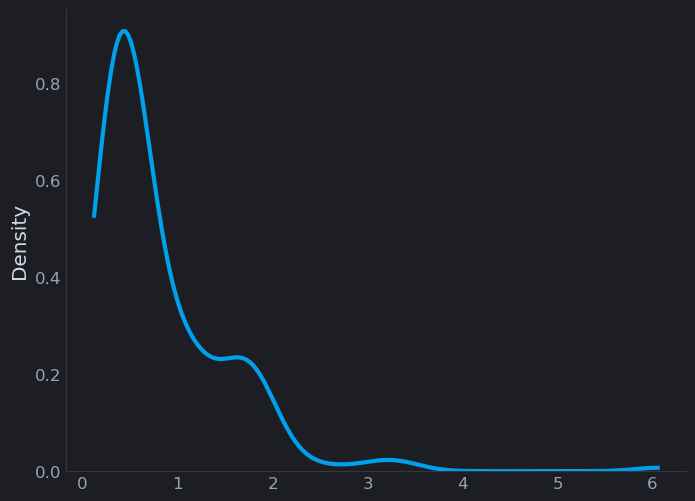

In [12]:
from glob import glob
import warnings
from pymatgen.core import Structure
from tqdm import tqdm

warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

a = []
c = []
kind = []

for fn in tqdm(glob('/home/nicholas/mleg/icsd/CIF/*.cif')[::100]):
    try:
        struct = Structure.from_file(fn)
    except ValueError:
        continue
    lat = struct.lattice
    if lat.is_orthogonal and len(set(lat.abc)) == 2:
        if lat.a == lat.b:        
            # tetragonal
            a.append(lat.a)
            c.append(lat.c)
            kind.append('ab')
        elif lat.a == lat.c:
            a.append(lat.a)
            c.append(lat.b)
            kind.append('ac')
        elif lat.b == lat.c:
            a.append(lat.b)
            c.append(lat.a)
            kind.append('bc')
        else:
            raise ValueError('Uh oh!')
        

a = np.array(a)
c = np.array(c)

sns.kdeplot(a / c, cut=0)

In [ ]:
pd.Series(kind).value_counts()

ab    241
bc      2
Name: count, dtype: int64

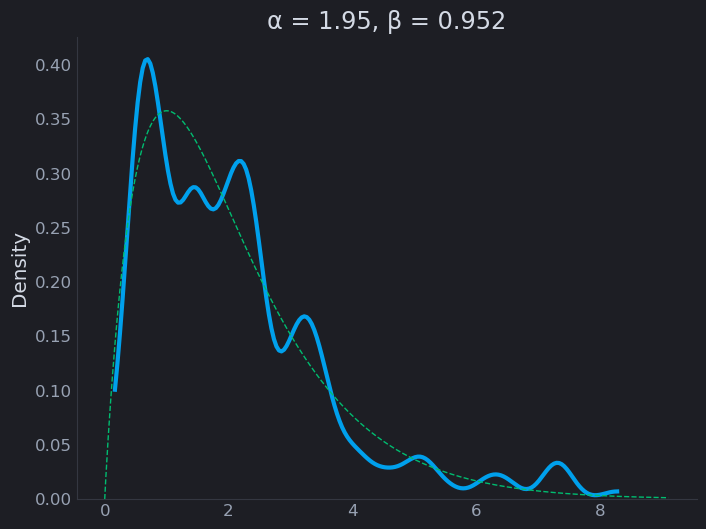

In [13]:
from scipy import stats
import torch
from pyro import distributions as dist

kwargs = dict(cut=0, bw=0.15)

y = c / a
xx = torch.linspace(0, y.max() * 1.1, 1000)

mu = 2.05
mode = 1.0

beta = 1 / (mu - mode)
alpha = mu * beta
yhat = torch.exp(dist.Gamma(alpha, beta).log_prob(xx))

sns.kdeplot(y, **kwargs)
plt.plot(xx.numpy(), yhat.numpy(), color=cs[1], ls='--', lw=1)
plt.title(f'α = {alpha:.3}, β = {beta:.3}');

In [14]:
import numpy as np
vol = a ** 2 * c
norm_a = a * (68 / vol) ** (1/3)
norm_c = c * (68 / vol) ** (1/3)

print(np.mean(norm_a), np.mean(norm_c))
print(np.std(norm_a), np.std(norm_c))

3.5898472167858477 6.336029029488175
0.9264753231579261 3.0841990363692737


100%|██████████| 1518/1518 [00:13<00:00, 113.31it/s]


<Axes: ylabel='Density'>

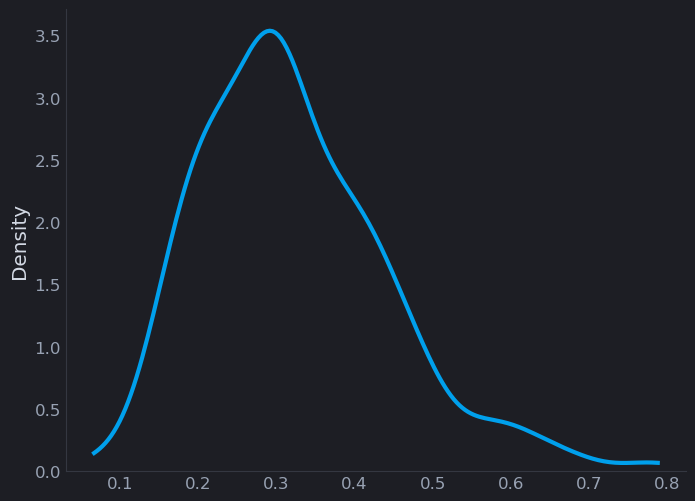

In [15]:
from glob import glob
import warnings
from tqdm import tqdm

warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

a = []
b = []
c = []
kind = []

for fn in tqdm(glob('/home/nicholas/mleg/icsd/CIF/*.cif')[::100]):
    try:
        struct = Structure.from_file(fn)
    except ValueError:
        continue
    lat = struct.lattice
    if lat.is_orthogonal and len(set(lat.abc)) == 3:
        a.append(lat.a)
        b.append(lat.b)
        c.append(lat.c)
        

a = np.array(a)
b = np.array(b)
c = np.array(c)

sns.kdeplot(a / (a + b + c), cut=0)

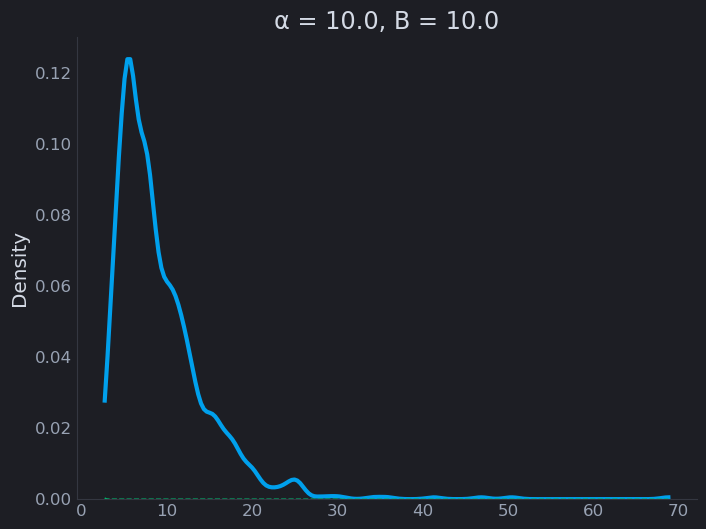

In [ ]:
from scipy import stats
import torch
from pyro import distributions as dist

kwargs = dict(cut=0, bw=0.15)

y = np.hstack([a, b, c])
xx = torch.linspace(y.min(), y.max(), 1000)

alpha = 10.
beta = 10.

yhat = torch.exp(dist.Gamma(alpha, beta).log_prob(xx))

sns.kdeplot(y, **kwargs)
plt.plot(xx.numpy(), yhat.numpy(), color=cs[1], ls='--', lw=1)
plt.title(f'α = {alpha:.3}, B = {beta:.3}');

In [21]:
lats = []
for fn in tqdm(glob('/home/nicholas/mleg/icsd/CIF/*.cif')[::100]):
    try:
        struct = Structure.from_file(fn)
    except ValueError:
        continue
    lat = struct.lattice
    if not any(np.isclose(lat.angles, 90)) and len(set(lat.abc)) == 3:
        lats.append(lat)

100%|██████████| 1518/1518 [00:13<00:00, 108.59it/s]


In [59]:
lats_n = [lat.scale(1) for lat in lats]
abc = np.array([lat.abc for lat in lats_n])
angs = np.array([lat.angles for lat in lats_n])

In [60]:
mats = np.array([lat.scale(68).matrix for lat in lats])

print(np.mean(mats, axis=0).round(2))
print(np.std(mats, axis=0).round(2))

[[ 3.71  0.   -0.1 ]
 [-0.08  4.16 -0.21]
 [ 0.    0.    4.65]]
[[0.68 0.   0.97]
 [1.16 0.75 1.27]
 [0.   0.   0.99]]


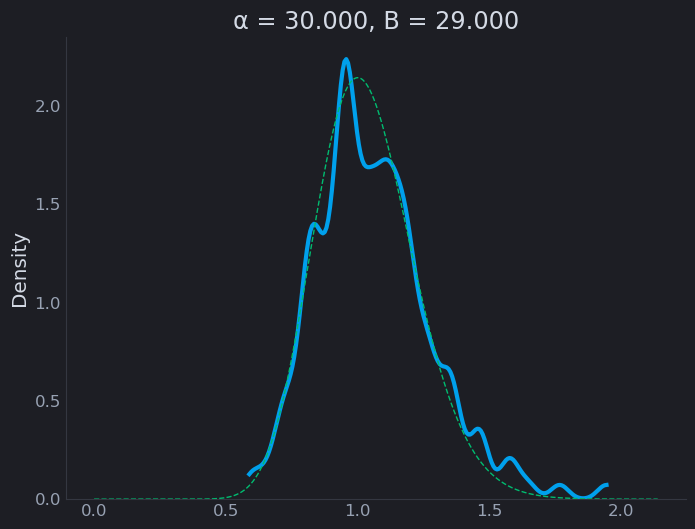

In [69]:
from math import log
from scipy import stats
import torch
from pyro import distributions as dist

kwargs = dict(cut=0, bw=0.15)

y = abc.flatten()
xx = torch.linspace(0, y.max() * 1.1, 1000)

alpha = 30.
beta = 29.

yhat = torch.exp(dist.Gamma(alpha, beta).log_prob(xx))

sns.kdeplot(y, **kwargs)
plt.plot(xx.numpy(), yhat.numpy(), color=cs[1], ls='--', lw=1)
plt.title(f'α = {alpha:.3f}, B = {beta:.3f}');

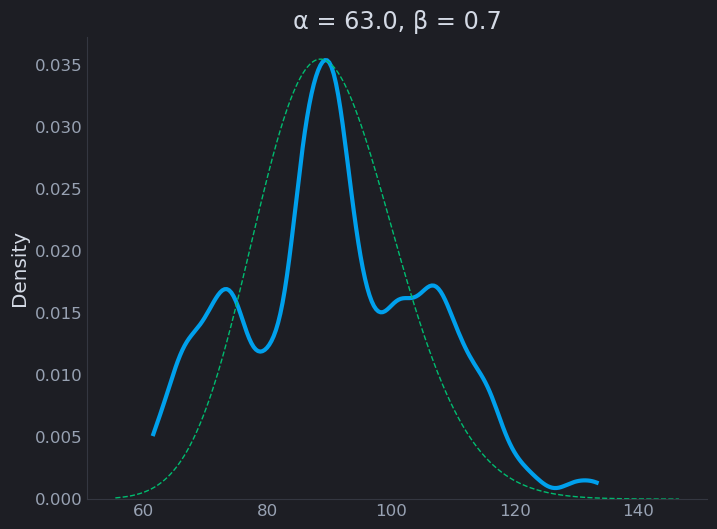

In [70]:
kwargs = dict(cut=0, bw=0.15)

y = angs.flatten()
xx = torch.linspace(y.min() * 0.9, y.max() * 1.1, 1000)

beta = 0.7
alpha = 90 * beta


yhat = torch.exp(dist.Gamma(alpha, beta).log_prob(xx))

sns.kdeplot(y, **kwargs)
plt.plot(xx.numpy(), yhat.numpy(), color=cs[1], ls='--', lw=1)
plt.title(f'α = {alpha:.3}, β = {beta:.3}');

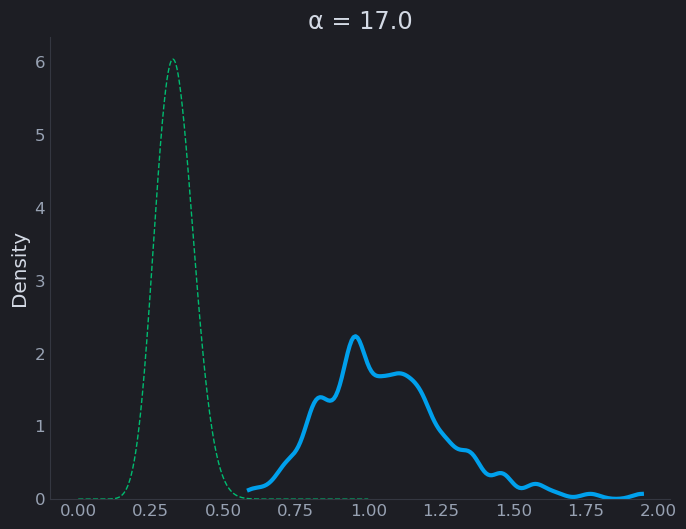

In [ ]:
from math import log
from scipy import stats
import torch
from pyro import distributions as dist

kwargs = dict(cut=0, bw=0.15)

y = abc.flatten()
xx = torch.linspace(0, 1, 1000)

alpha = 17.

yhat = torch.exp(dist.Beta(alpha, 2 * alpha).log_prob(xx))

sns.kdeplot(y, **kwargs)
plt.plot(xx.numpy(), yhat.numpy(), color=cs[1], ls='--', lw=1)
plt.title(f'α = {alpha:.3}');

In [ ]:
glob('/home/nicholas/mleg/icsd/CIF/')[::100]

/home/nicholas/anaconda3/envs/baysic/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/nicholas/anaconda3/envs/baysic/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: ylabel='Count'>

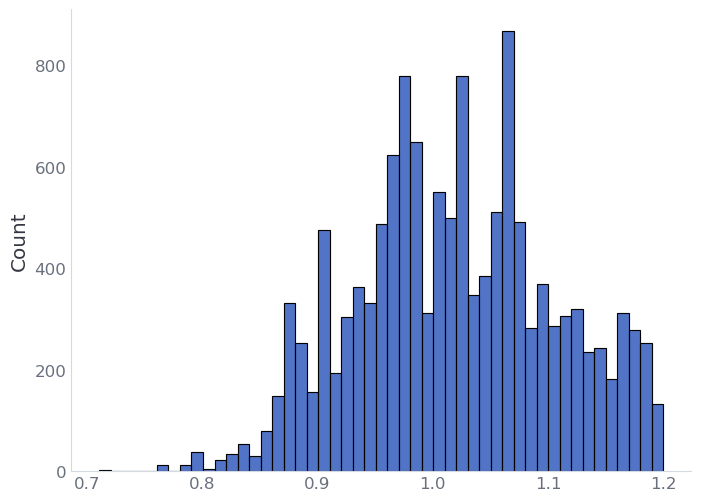

In [14]:
import matplotlib.pyplot as plt
import pyro.distributions as dist
import torch
from pymatgen.analysis.molecule_structure_comparator import CovalentRadius
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
vals = []
convs = [SpacegroupAnalyzer(struct).get_conventional_standard_structure() for struct in structs]
for struct in convs:
    radii = np.array([CovalentRadius.radius[site.specie.symbol] for site in struct.sites])
    cov_length = radii[np.newaxis, :] + radii[:, np.newaxis]
    atom_dist = struct.distance_matrix / cov_length
    atom_pdist = atom_dist[np.triu_indices_from(atom_dist, 1)]
    vals.append(atom_pdist)

vals = np.hstack(vals)

sns.histplot(vals[vals < 1.2])

In [15]:
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

df = pd.read_pickle('merged_test_data3.pkl')

sga = SpacegroupAnalyzer(df.iloc[0]['struct'])
symm = sga.get_conventional_standard_structure()
sga.get_symmetrized_structure().wyckoff_symbols

['4e', '4e', '4e', '4e', '4e']

In [16]:
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

df = pd.read_pickle('merged_test_data3.pkl')

sgas = []
symms = []
convs = []
wycks = []
for i, row in df.iterrows():
    sga = SpacegroupAnalyzer(row['struct'])
    sgas.append(sga)
    convs.append(sga.get_conventional_standard_structure())
    symm = sga.get_symmetrized_structure()
    symms.append(symm)
    wycks.append(list(symm.wyckoff_symbols))

flat_wycks = sum(wycks, [])

In [17]:
from pyxtal import Wyckoff_position

rows = []
for i, (sg, wsyms) in enumerate(zip(sgas, wycks)):
    for wsym in wsyms:
        rows.append([sg.get_space_group_number(), sg.get_symmetry_dataset()['international'], wsym[1], 
                     Wyckoff_position.from_group_and_letter(sg.get_space_group_number(), wsym), i])

wydf = pd.DataFrame(rows, columns=['sgn', 'symbol', 'letter', 'wp', 'struct_i'])
wydf['mult'] = [len(wp.ops) for wp in wydf['wp']]
wydf.head(10)

,sgn,symbol,letter,wp,struct_i,mult
0,14,P2_1/c,e,(Rot:\n[[1. 0. 0.]\n [0. 1. 0.]\n [0. 0. 1.]]\...,0,4
1,14,P2_1/c,e,(Rot:\n[[1. 0. 0.]\n [0. 1. 0.]\n [0. 0. 1.]]\...,0,4
2,14,P2_1/c,e,(Rot:\n[[1. 0. 0.]\n [0. 1. 0.]\n [0. 0. 1.]]\...,0,4
3,14,P2_1/c,e,(Rot:\n[[1. 0. 0.]\n [0. 1. 0.]\n [0. 0. 1.]]\...,0,4
4,14,P2_1/c,e,(Rot:\n[[1. 0. 0.]\n [0. 1. 0.]\n [0. 0. 1.]]\...,0,4
5,189,P-62m,f,(Rot:\n[[1. 0. 0.]\n [0. 0. 0.]\n [0. 0. 0.]]\...,1,3
6,189,P-62m,g,(Rot:\n[[1. 0. 0.]\n [0. 0. 0.]\n [0. 0. 0.]]\...,1,3
7,189,P-62m,d,(Rot:\n[[0. 0. 0.]\n [0. 0. 0.]\n [0. 0. 0.]]\...,1,2
8,189,P-62m,a,(Rot:\n[[0. 0. 0.]\n [0. 0. 0.]\n [0. 0. 0.]]\...,1,1
9,2,P-1,i,(Rot:\n[[1. 0. 0.]\n [0. 1. 0.]\n [0. 0. 1.]]\...,2,2


In [18]:
wydf['num_atoms'] = [convs[i].num_sites for i in wydf['struct_i']]
wydf['sets'] = [convs[i].composition.values() for i in wydf['struct_i']]
wydf['max_card'] = [max(convs[i].composition.values()) for i in wydf['struct_i']]
wydf['len_el'] = [len(convs[i].composition.values()) for i in wydf['struct_i']]

wydf.head()

,sgn,symbol,letter,wp,struct_i,mult,num_atoms,sets,max_card,len_el
0,14,P2_1/c,e,(Rot:\n[[1. 0. 0.]\n [0. 1. 0.]\n [0. 0. 1.]]\...,0,4,20,"(4.0, 4.0, 12.0)",12.0,3
1,14,P2_1/c,e,(Rot:\n[[1. 0. 0.]\n [0. 1. 0.]\n [0. 0. 1.]]\...,0,4,20,"(4.0, 4.0, 12.0)",12.0,3
2,14,P2_1/c,e,(Rot:\n[[1. 0. 0.]\n [0. 1. 0.]\n [0. 0. 1.]]\...,0,4,20,"(4.0, 4.0, 12.0)",12.0,3
3,14,P2_1/c,e,(Rot:\n[[1. 0. 0.]\n [0. 1. 0.]\n [0. 0. 1.]]\...,0,4,20,"(4.0, 4.0, 12.0)",12.0,3
4,14,P2_1/c,e,(Rot:\n[[1. 0. 0.]\n [0. 1. 0.]\n [0. 0. 1.]]\...,0,4,20,"(4.0, 4.0, 12.0)",12.0,3


/home/nicholas/anaconda3/envs/baysic/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/nicholas/anaconda3/envs/baysic/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



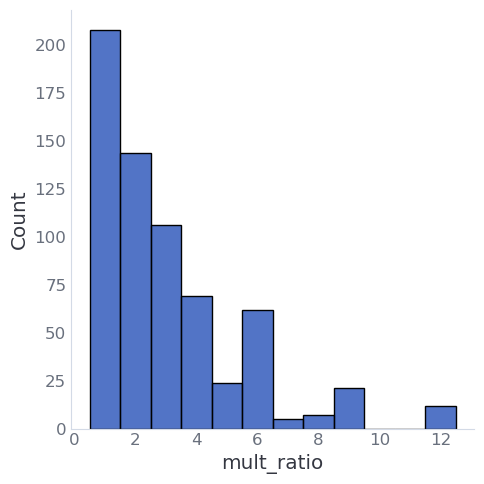

In [19]:
sns.displot(wydf.eval('mult_ratio = max_card/mult'), x='mult_ratio', discrete=True)

/home/nicholas/anaconda3/envs/baysic/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/nicholas/anaconda3/envs/baysic/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='letter', ylabel='Density'>

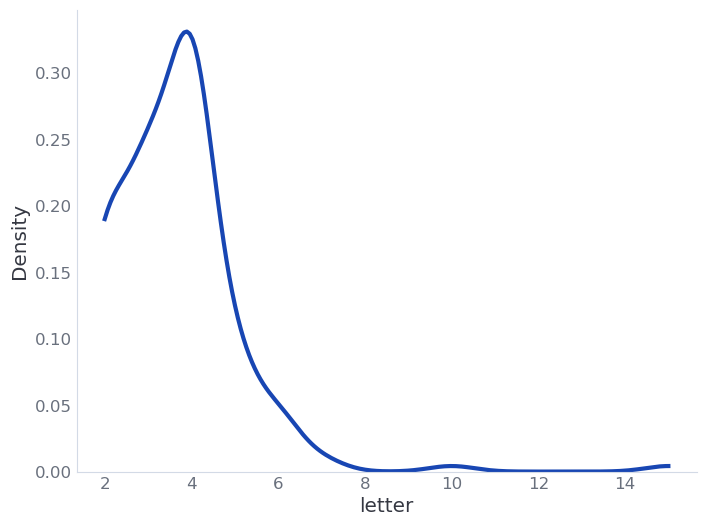

In [26]:
grp = wydf.groupby('struct_i')
sns.kdeplot(grp.count()['letter'], cut=0)

In [65]:
cubic = df.query('CrystalSystem == "Cubic"').index
wydf['pat'] = ['_'.join([str(int(x)) for x in sorted(sets)[::-1]]) for sets in wydf['sets']]
pat_grps = wydf.query('struct_i in @cubic').groupby('pat')
pat_grps.count()

,sgn,symbol,letter,wp,struct_i,mult,num_atoms,sets,max_card,len_el
pat,,,,,,,,,,
12_12_8_6,4,4,4,4,4,4,4,4,4,4
12_4,3,3,3,3,3,3,3,3,3,3
12_8_6_2,4,4,4,4,4,4,4,4,4,4
16_12_12,9,9,9,9,9,9,9,9,9,9
16_16_16_4,4,4,4,4,4,4,4,4,4,4
16_4_4,9,9,9,9,9,9,9,9,9,9
1_1,10,10,10,10,10,10,10,10,10,10
24_12_4,4,4,4,4,4,4,4,4,4,4
24_8_2,11,11,11,11,11,11,11,11,11,11


In [68]:
wydf

,sgn,symbol,letter,wp,struct_i,mult,num_atoms,sets,max_card,len_el,pat
0,14,P2_1/c,e,(Rot:\n[[1. 0. 0.]\n [0. 1. 0.]\n [0. 0. 1.]]\...,0,4,20,"(4.0, 4.0, 12.0)",12.0,3,12_4_4
1,14,P2_1/c,e,(Rot:\n[[1. 0. 0.]\n [0. 1. 0.]\n [0. 0. 1.]]\...,0,4,20,"(4.0, 4.0, 12.0)",12.0,3,12_4_4
2,14,P2_1/c,e,(Rot:\n[[1. 0. 0.]\n [0. 1. 0.]\n [0. 0. 1.]]\...,0,4,20,"(4.0, 4.0, 12.0)",12.0,3,12_4_4
3,14,P2_1/c,e,(Rot:\n[[1. 0. 0.]\n [0. 1. 0.]\n [0. 0. 1.]]\...,0,4,20,"(4.0, 4.0, 12.0)",12.0,3,12_4_4
4,14,P2_1/c,e,(Rot:\n[[1. 0. 0.]\n [0. 1. 0.]\n [0. 0. 1.]]\...,0,4,20,"(4.0, 4.0, 12.0)",12.0,3,12_4_4
...,...,...,...,...,...,...,...,...,...,...,...
653,71,Immm,l,(Rot:\n[[0. 0. 0.]\n [0. 1. 0.]\n [0. 0. 1.]]\...,178,8,32,"(8.0, 16.0, 8.0)",16.0,3,16_8_8
654,71,Immm,l,(Rot:\n[[0. 0. 0.]\n [0. 1. 0.]\n [0. 0. 1.]]\...,178,8,32,"(8.0, 16.0, 8.0)",16.0,3,16_8_8
655,220,I-43d,b,(Rot:\n[[0. 0. 0.]\n [0. 0. 0.]\n [0. 0. 0.]]\...,179,12,40,"(12.0, 16.0, 12.0)",16.0,3,16_12_12
656,220,I-43d,c,(Rot:\n[[1. 0. 0.]\n [1. 0. 0.]\n [1. 0. 0.]]\...,179,16,40,"(12.0, 16.0, 12.0)",16.0,3,16_12_12


In [78]:
from baysic.lattice import CubicLattice
from baysic.pyro_generator import SystemStructureModel

struct_is = pat_grps.first()['struct_i']
pat_dists = []
for pat_i in pat_grps.count().query('sgn > 5').index:
    mod = SystemStructureModel(convs[struct_is[pat_i]].composition, CubicLattice)
    counts = mod.count_cards.numpy()
    factor = len(sum(mod.wyckoff_options[0], [])) + 1
    counts *= factor / (counts[0])
    counts -= 1
    pat_dists.append(counts.round())

pat_dists = pd.Series(pat_dists, pat_grps.count().query('sgn > 5').index)
pat_dists

pat
16_12_12    [12.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11....
16_4_4      [8.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, ...
1_1         [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...
24_8_2      [10.0, 10.0, 9.0, 9.0, 8.0, 10.0, 9.0, 9.0, 8....
24_8_4_4    [12.0, 11.0, 10.0, 11.0, 10.0, 11.0, 10.0, 10....
24_8_6_2    [12.0, 11.0, 10.0, 11.0, 10.0, 11.0, 10.0, 10....
3_1         [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...
4_4_4_4     [6.0, 6.0, 6.0, 5.0, 6.0, 6.0, 6.0, 5.0, 6.0, ...
8_4_4       [6.0, 6.0, 6.0, 5.0, 6.0, 6.0, 5.0, 6.0, 6.0, ...
dtype: object

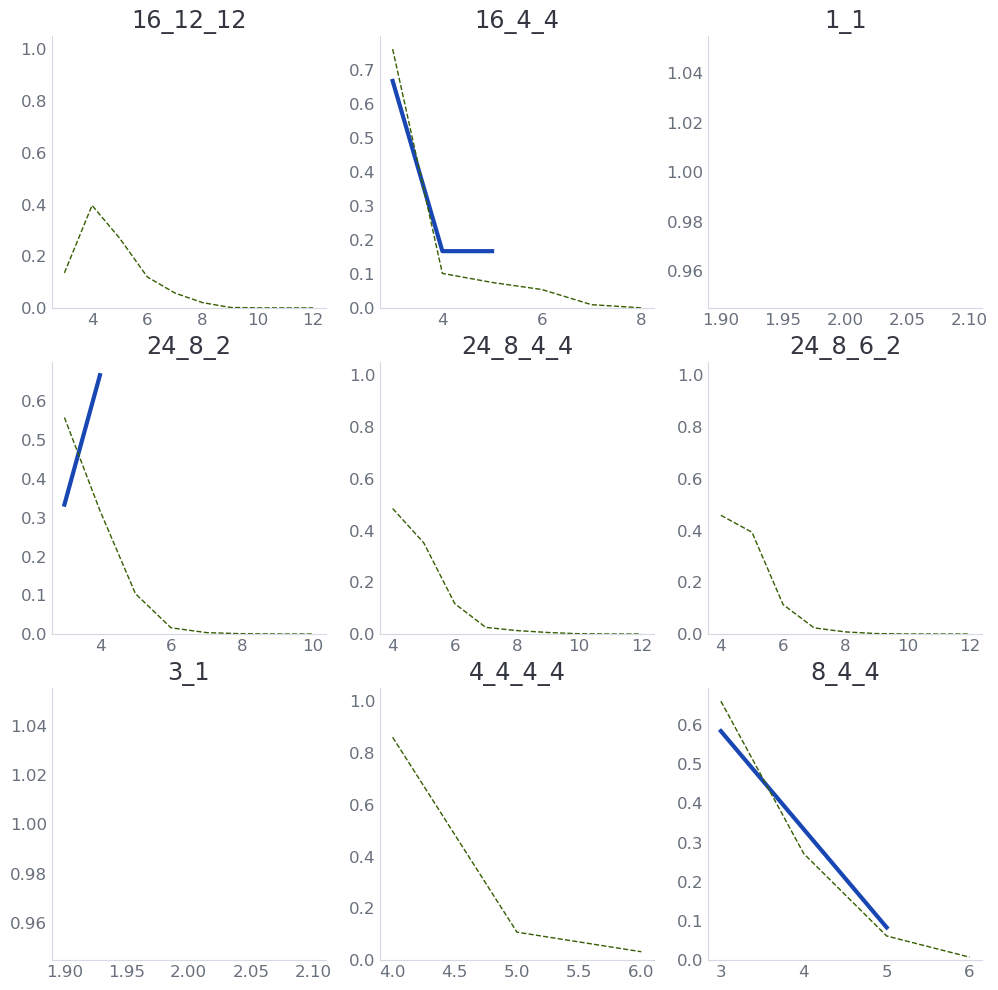

In [94]:
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

kwargs = dict(stat='density', fill=False, element='poly', discrete=True)
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
for pat, ax in zip(pat_dists.index, axs.flatten()):
    sns.histplot(wydf.query('pat == @pat').groupby('struct_i').count()['letter'], **kwargs, ax=ax)
    count = pd.Series(pat_dists[pat]).value_counts().sort_index()
    count *= 0.2 ** (count.index - min(count.index))
    ax.plot(count.index, count.values / sum(count.values), ls='--', lw=1)
    ax.set_title(pat)
    ax.set_xlabel('') 
    ax.set_ylabel('')